# Projet : IMBD Movies (Dataset Kaggle)

## Introduction

Ce projet a pour but d'étudier les notes attribuées par les critiques et le public sur 1000 films durant un siècle (années 1920 à 2020). L'objectif de cette analyse : 

• Nettoyer et assurer l'intégrité des données : gestion des doublons et des données manquantes

• Analayser la distribution des variables : comprendre les caractéristiques et les tendances sur les films

Après ces différentes étapes, le jeu de données final sera utilisé pour la création d'un tableau de bord sous PowerBi.

## Traitement des données

### Installation et import des packages

In [1]:
# Installation du package Kaggle
!pip install kagglehub

In [2]:
# Import des packages
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

### Import du dataset

In [3]:
# Définition du chemin d'accès et du fichier
path = kagglehub.dataset_download("harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows")
fichier = 'imdb_top_1000.csv'

# Création du chemin complet
chemin = f"{path}/{fichier}"

In [4]:
# Import des données
df=pd.read_csv(chemin)
print(df.columns)
print(df)

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')
                                           Poster_Link  \
0    https://m.media-amazon.com/images/M/MV5BMDFkYT...   
1    https://m.media-amazon.com/images/M/MV5BM2MyNj...   
2    https://m.media-amazon.com/images/M/MV5BMTMxNT...   
3    https://m.media-amazon.com/images/M/MV5BMWMwMG...   
4    https://m.media-amazon.com/images/M/MV5BMWU4N2...   
..                                                 ...   
995  https://m.media-amazon.com/images/M/MV5BNGEwMT...   
996  https://m.media-amazon.com/images/M/MV5BODk3Yj...   
997  https://m.media-amazon.com/images/M/MV5BM2U3Yz...   
998  https://m.media-amazon.com/images/M/MV5BZTBmMj...   
999  https://m.media-amazon.com/images/M/MV5BMTY5OD...   

                 Series_Title Released_Year Certificate  Runtim

### Exploration des données

In [5]:
# Affichage du nombre et du type de données
df_clean=df.copy()
print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB
None


#### Etude des distrubution des données

##### Variable 'Certificate'

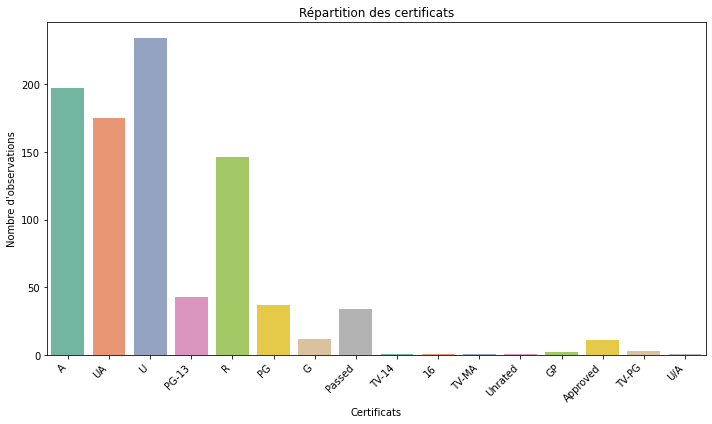

In [6]:
# Variable Certificate
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='Certificate', palette='Set2')
plt.title('Répartition des certificats')
plt.xlabel('Certificats')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=45, ha='right')  # Si les labels sont longs, les faire pivoter
plt.tight_layout()
plt.show()

On observe que cette variable a 16 modalités, cependant certaines sont très peu représentées. Je peux envisager de les regrouper selon le besoin final.

##### Variable 'Runtime'

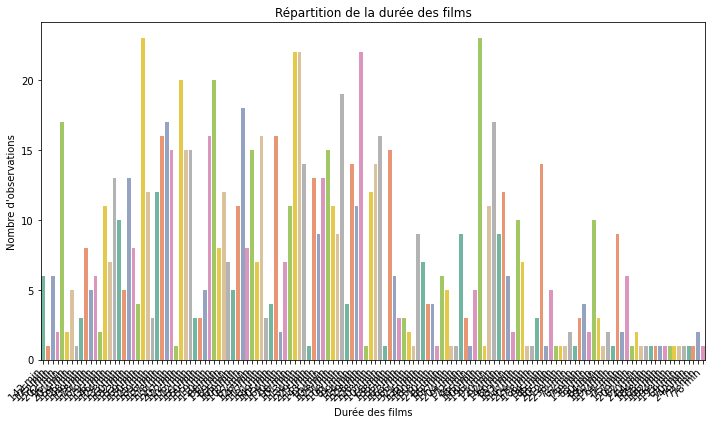

In [7]:
# Variables Runtime
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='Runtime', palette='Set2')
plt.title('Répartition de la durée des films')
plt.xlabel('Durée des films')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=45, ha='right')  # Si les labels sont longs, les faire pivoter
plt.tight_layout()
plt.show()

Cette variable est en format caractère et non numérique comme elle devrait être. Je vais donc devoir modifier le type de la variable.

In [8]:
# Modification du type de la variable 'Runtime'
df_clean["runtime_minutes"] = df_clean["Runtime"].str.extract(r"(\d+)").astype(int)
df_clean= df_clean.drop(columns=['Runtime'])

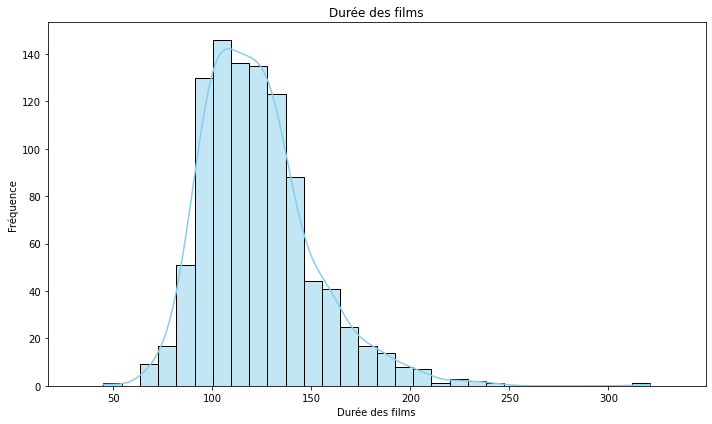

In [9]:
# Afficher la répartition de la durée des films après modifcation du type de la variable
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['runtime_minutes'], kde=True, color='skyblue', bins=30)
plt.title('Durée des films')
plt.xlabel('Durée des films')
plt.ylabel('Fréquence')
plt.xlim(df_clean['runtime_minutes'].min() - df_clean['runtime_minutes'].std(), df_clean['runtime_minutes'].max() + df_clean['runtime_minutes'].std())  # Ajustement dynamique axe x
plt.tight_layout()
plt.show()

Ici, la durée des films varient entre 50min et 300min. Une bonne partie des films ont une durée entre 90min et 140min (1h30 et 2h20). On remarque que la distribution est légèrement asymétrique à droite.

##### Variable 'Genre'

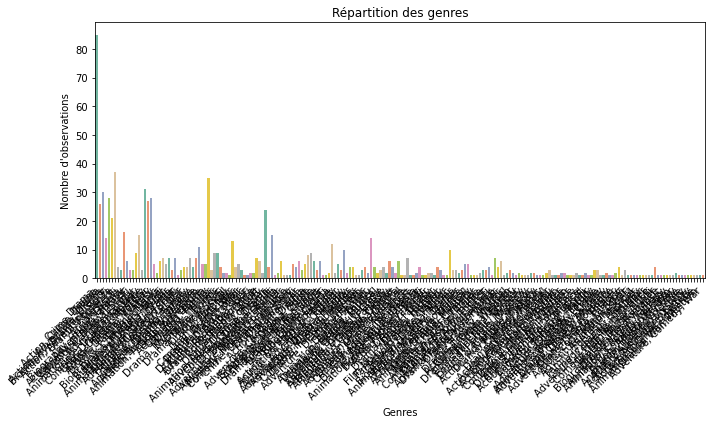

In [10]:
# Variable Genre
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='Genre', palette='Set2')
plt.title('Répartition des genres')
plt.xlabel('Genres')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=45, ha='right')  # Si les labels sont longs, les faire pivoter
plt.tight_layout()
plt.show()

In [11]:
# Listing des modalités de la variable 'Genre'
df_clean["Genre"].unique()

array(['Drama', 'Crime, Drama', 'Action, Crime, Drama',
       'Action, Adventure, Drama', 'Biography, Drama, History',
       'Action, Adventure, Sci-Fi', 'Drama, Romance', 'Western',
       'Action, Sci-Fi', 'Biography, Crime, Drama',
       'Action, Adventure, Fantasy', 'Comedy, Drama, Thriller',
       'Adventure, Drama, Sci-Fi', 'Animation, Adventure, Family',
       'Drama, War', 'Crime, Drama, Fantasy', 'Comedy, Drama, Romance',
       'Crime, Drama, Mystery', 'Crime, Drama, Thriller',
       'Action, Drama, Mystery', 'Drama, Family, Fantasy', 'Drama, Music',
       'Biography, Comedy, Drama', 'Drama, Mystery, Sci-Fi',
       'Biography, Drama, Music', 'Crime, Mystery, Thriller',
       'Animation, Adventure, Drama', 'Animation, Drama, War',
       'Adventure, Comedy, Sci-Fi', 'Horror, Mystery, Thriller',
       'Drama, Romance, War', 'Comedy, Drama, Family',
       'Animation, Drama, Fantasy', 'Action, Biography, Drama',
       'Animation, Action, Adventure', 'Drama, Western',


En ce qui concerne cette variable, de nombreux genres existent. La variable est formée de cette façon : "Genre1,Genre2,Genre3". Pour un film, cela peut être action-humour et pour un autre action-romantique. 
J'ai réfléchi à deux solutions pour traiter cette variable afin qu'elle puisse être exploitable. J'ai pensé à me concentréer sur un seul type de film, mais cela réduisait fortement la taille du jeu de données. L'analyse finale via un tableau de bord serait plus limitée car je voulais plutôt étudier les différences de votes, recettes etc. entre les genres. La deuxième option est de ne garder que le premier genre qui apparaît dans chaque modalité. Il y aurait quand même une perte d'information. Cependant, cette solution nous permet de garder le genre principal, qui est l'information la plus importante selon moi.

In [28]:
# Modification de la variable 'Genre' : Garder que le premier genre
df_clean["Genre"]=df_clean["Genre"].str.split(",").str[0].str.strip()

In [27]:
# Vérification du changement de type
df_clean

,Poster_Link,Series_Title,Released_Year,Certificate,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,runtime_minutes
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994.0,A,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,142
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972.0,A,Crime,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,175
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008.0,UA,Action,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,152
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974.0,A,Crime,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,202
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957.0,U,Crime,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,https://m.media-amazon.com/images/M/MV5BNGEwMT...,Breakfast at Tiffany's,1961.0,A,Comedy,7.6,A young New York socialite becomes interested ...,76.0,Blake Edwards,Audrey Hepburn,George Peppard,Patricia Neal,Buddy Ebsen,166544,NaN,115
996,https://m.media-amazon.com/images/M/MV5BODk3Yj...,Giant,1956.0,G,Drama,7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,Elizabeth Taylor,Rock Hudson,James Dean,Carroll Baker,34075,NaN,201
997,https://m.media-amazon.com/images/M/MV5BM2U3Yz...,From Here to Eternity,1953.0,Passed,Drama,7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,30500000.0,118
998,https://m.media-amazon.com/images/M/MV5BZTBmMj...,Lifeboat,1944.0,NaN,Drama,7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,26471,NaN,97


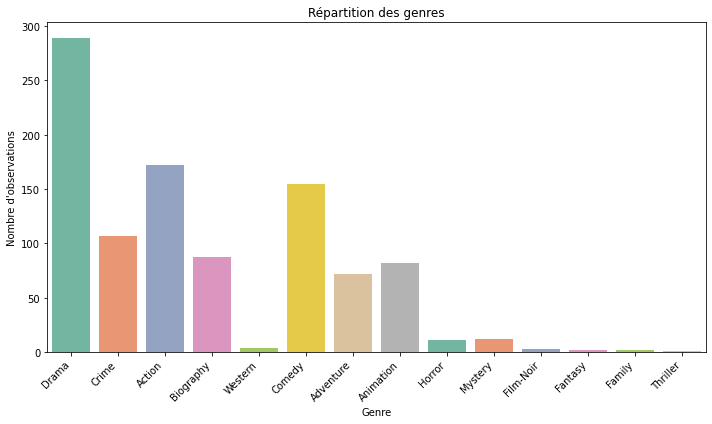

In [29]:
# Vérification des modifications de la variable 'Genre' par graphique
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='Genre', palette='Set2')
plt.title('Répartition des genres')
plt.xlabel('Genre')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=45, ha='right')  # Si les labels sont longs, les faire pivoter
plt.tight_layout()
plt.show()

##### Variable 'Director'

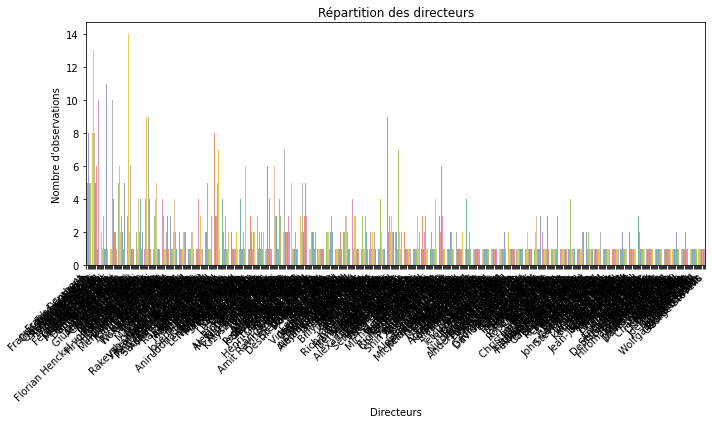

In [ ]:
# Variable Director
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='Director', palette='Set2')
plt.title('Répartition des directeurs')
plt.xlabel('Directeurs')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=45, ha='right')  # Si les labels sont longs, les faire pivoter
plt.tight_layout()
plt.show()

Il y a un grand nombre de directeurs de films différents. On ne peut pas s'assurer qu'un même directeur soit orthographié pareil. Un traitement peut être envisagé.

##### Variable 'Released_Year'

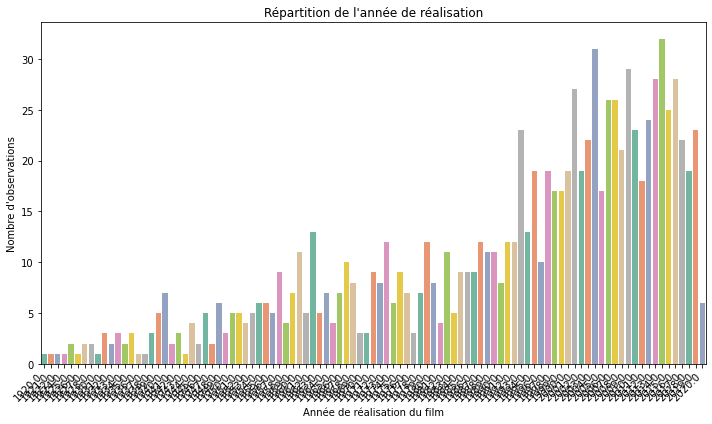

In [25]:
# Variable année de réalisation
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='Released_Year', palette='Set2')
plt.title('Répartition de l\'année de réalisation')
plt.xlabel('Année de réalisation du film')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=45, ha='right')  # Si les labels sont longs, les faire pivoter
plt.tight_layout()
plt.show()

Cette variable (comme la durée des films) est en format caractère. Cependant, comme il s'agit d'années, cela est censé être une variable continue (numérique). Un changement de type va être réalisé.

In [17]:
# Modification du type de données de la variable "Released_Year"
df_clean["Released_Year"] = pd.to_numeric(df_clean["Released_Year"], errors='coerce')

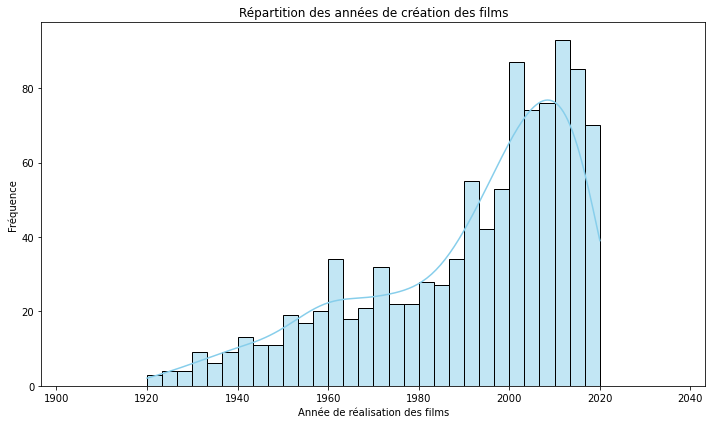

In [24]:
# Vérification du changement de type de la variable pour pouvoir étudier sa répartition
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Released_Year'], kde=True, color='skyblue', bins=30)
plt.title('Répartition des années de création des films')
plt.xlabel('Année de réalisation des films')
plt.ylabel('Fréquence')
plt.xlim(df_clean['Released_Year'].min() - df_clean['Released_Year'].std(), df_clean['Released_Year'].max() + df_clean['Released_Year'].std())  # Ajustement dynamique axe x
plt.tight_layout()
plt.show()

Les années de réalisation des films varient entre 1920 et 2020. La distribution présente un ou plusieurs pics significatifs, souvent autour des années 1990 à 2010. Cela indique que, bien que des classiques plus anciens soient inclus, le jeu données est fortement pondérée par les films modernes.

##### Variable 'IMDB note'

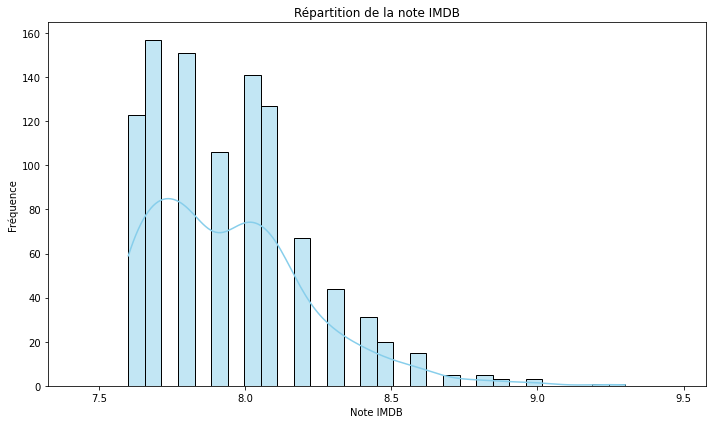

In [21]:
# Variable imdb note
plt.figure(figsize=(10, 6))
sns.histplot(df['IMDB_Rating'], kde=True, color='skyblue', bins=30)
plt.title('Répartition de la note IMDB')
plt.xlabel('Note IMDB')
plt.ylabel('Fréquence')
plt.xlim(df['IMDB_Rating'].min() - df['IMDB_Rating'].std(), df['IMDB_Rating'].max() + df['IMDB_Rating'].std())  # Ajustement dynamique axe x
plt.tight_layout()
plt.show()

La note IMDB est une note comprise entre 0 et 10. Ici, nous pouvons voir que les notes se situent autour de 8.

##### Variable 'Gross'

Nous savons d'avance que la variable 'Gross' (recettes des films) est en type caractère. Le type de variable doit être changé pour exploiter la variable au mieux.

In [22]:
# Changement de type (caractère en numérique)
df_clean["Gross"] = df_clean["Gross"].str.replace(",","").astype(float)

In [23]:
# Vérification du changement de type
df_clean

,Poster_Link,Series_Title,Released_Year,Certificate,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,runtime_minutes
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994.0,A,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,142
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972.0,A,Crime,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,175
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008.0,UA,Action,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,152
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974.0,A,Crime,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,202
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957.0,U,Crime,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,https://m.media-amazon.com/images/M/MV5BNGEwMT...,Breakfast at Tiffany's,1961.0,A,Comedy,7.6,A young New York socialite becomes interested ...,76.0,Blake Edwards,Audrey Hepburn,George Peppard,Patricia Neal,Buddy Ebsen,166544,NaN,115
996,https://m.media-amazon.com/images/M/MV5BODk3Yj...,Giant,1956.0,G,Drama,7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,Elizabeth Taylor,Rock Hudson,James Dean,Carroll Baker,34075,NaN,201
997,https://m.media-amazon.com/images/M/MV5BM2U3Yz...,From Here to Eternity,1953.0,Passed,Drama,7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,30500000.0,118
998,https://m.media-amazon.com/images/M/MV5BZTBmMj...,Lifeboat,1944.0,NaN,Drama,7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,26471,NaN,97


### Nettoyage des données

##### Gestion des doublons

Dans un premier temps, il est important de vérifier qu'il n'y a pas de lignes en double dans le dataset.

In [ ]:
# Identifier les valeurs dupliquées (toutes les occurrences)
doublons_masque = df_clean['Series_Title'].duplicated(keep=False)

# Filtrer le jeu de données pour obtenir les lignes dupliquées
lignes_completes_doublons = df_clean[doublons_masque]

# Afficher le résultat
print("Lignes complètes correspondant aux titres de films en double :")
print(lignes_completes_doublons)

Lignes complètes correspondant aux titres de films en double :
                                           Poster_Link Series_Title  \
87   https://m.media-amazon.com/images/M/MV5BYmY3Mz...     Drishyam   
136  https://m.media-amazon.com/images/M/MV5BYmJhZm...     Drishyam   

     Released_Year Certificate  Genre  IMDB_Rating  \
87          2013.0           U  Crime          8.3   
136         2015.0          UA  Crime          8.2   

                                              Overview  Meta_score  \
87   A man goes to extreme lengths to save his fami...         NaN   
136  Desperate measures are taken by a man who trie...         NaN   

            Director       Star1         Star2         Star3         Star4  \
87     Jeethu Joseph    Mohanlal         Meena  Asha Sharath        Ansiba   
136  Nishikant Kamat  Ajay Devgn  Shriya Saran          Tabu  Rajat Kapoor   

     No_of_Votes     Gross  runtime_minutes  
87         30722       NaN              160  
136        70367  7394

Dans ce cas, nous retrouvons deux films ayant le même titre, mais ces deux films ne sont pas sortis la même année. De plus, toutes les autres variables sont différentes pour ces deux films. La conclusion est qu'il y a pas de doublon dans le jeu de données.

#### Gestion des données manquantes

Après un regard rapide sur le jeu de données, certaines variables ont des données manquantes. Dans un premier temps, il faut étudier le type de données, ainsi que le nombre de données qui sont manquantes avant d'envisager certains traitements.

In [ ]:
# Vérification des données manquantes par variable
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Poster_Link      1000 non-null   object 
 1   Series_Title     1000 non-null   object 
 2   Released_Year    999 non-null    float64
 3   Certificate      899 non-null    object 
 4   Genre            1000 non-null   object 
 5   IMDB_Rating      1000 non-null   float64
 6   Overview         1000 non-null   object 
 7   Meta_score       843 non-null    float64
 8   Director         1000 non-null   object 
 9   Star1            1000 non-null   object 
 10  Star2            1000 non-null   object 
 11  Star3            1000 non-null   object 
 12  Star4            1000 non-null   object 
 13  No_of_Votes      1000 non-null   int64  
 14  Gross            831 non-null    float64
 15  runtime_minutes  1000 non-null   int32  
dtypes: float64(4), int32(1), int64(1), object(10)
memory usage: 1

Au vu du nombre données manquantes, la méthode des K-plus-proche-voisin (Knn) va être utilisée. Cette méthode consiste à remplacer les valeurs manquantes par les k lignes les plus proches. Ici, les valeurs manquantes sont remplacée en fonction des 5 valeurs les plus proches.

In [ ]:
# Méthode des KNN
df_knn = df_clean.copy()

# Encodage des variables catégorielles
categorical_cols = ['Poster_Link','Series_Title', 'Certificate', 'Genre','Overview','Director', 'Star1', 'Star2', 'Star3', 'Star4']
encoder_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col].astype(str))
    encoder_dict[col] = le

# Vérification que toutes les variables sont numériques
for col in df_knn.columns:
    df_knn[col] = pd.to_numeric(df_knn[col], errors='coerce')

# Normaliser
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_knn), columns=df_knn.columns)

# Imputater KNN
imputer = KNNImputer(n_neighbors=5, weights="distance")
df_imputed = pd.DataFrame(imputer.fit_transform(df_scaled), columns=df_scaled.columns)

# Rétablir l’échelle d’origine
df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed), columns=df_knn.columns)

# Décoder des variables catégorielles
for col in categorical_cols:
    df_imputed[col] = encoder_dict[col].inverse_transform(df_imputed[col].round().astype(int))

df_clean_na = df_imputed.copy()


In [ ]:
# Vérification qu'il ne reste plus de données manquantes
df_clean_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Poster_Link      1000 non-null   object 
 1   Series_Title     1000 non-null   object 
 2   Released_Year    1000 non-null   float64
 3   Certificate      1000 non-null   object 
 4   Genre            1000 non-null   object 
 5   IMDB_Rating      1000 non-null   float64
 6   Overview         1000 non-null   object 
 7   Meta_score       1000 non-null   float64
 8   Director         1000 non-null   object 
 9   Star1            1000 non-null   object 
 10  Star2            1000 non-null   object 
 11  Star3            1000 non-null   object 
 12  Star4            1000 non-null   object 
 13  No_of_Votes      1000 non-null   float64
 14  Gross            1000 non-null   float64
 15  runtime_minutes  1000 non-null   float64
dtypes: float64(6), object(10)
memory usage: 125.1+ KB


#### Nettoyage des données aberrantes

Une fois que les données manquantes ont été traitées, il est nécessaire de vérifier si des données sont éloignées des autres valeurs (valeurs aberrantes).

##### Variable 'IMDB_Rating'

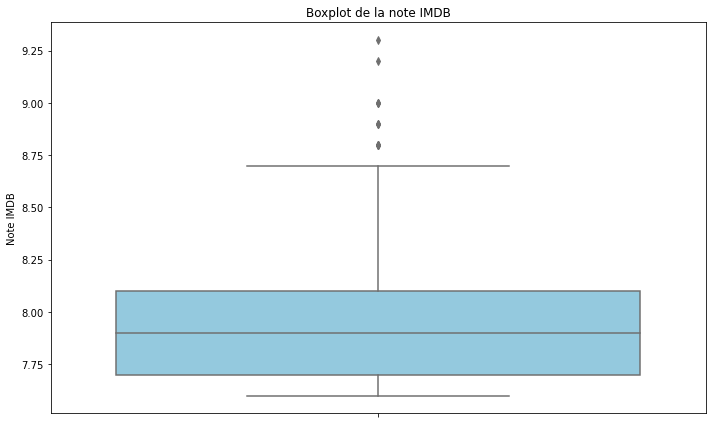

In [ ]:
# Variable IMDB Rating
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, y='IMDB_Rating', color='skyblue')
plt.title('Boxplot de la note IMDB')
plt.ylabel('Note IMDB')
plt.tight_layout()
plt.show()

En ce qui concerne la note IMDB, elle doit être comprise entre 0 et 10. Ici nous constatons qu'aucune des notes n'est en dehors de cet intervalle. Cependant, on observe certaines notes élevées. Ces valeurs peuvent être considérées comme des valeurs non aberrantes.

##### Variable 'Released_Year'

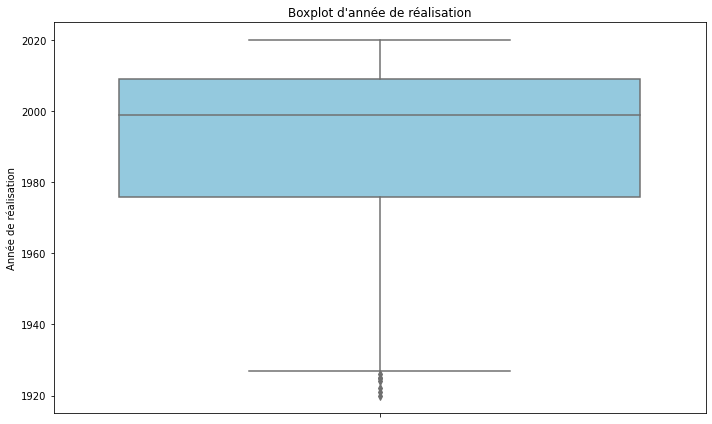

In [ ]:
# Année de réalisation
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, y='Released_Year', color='skyblue')
plt.title('Boxplot d\'année de réalisation')
plt.ylabel('Année de réalisation')
plt.tight_layout()
plt.show()

Nous pouvons voir, comme précédemment qu'aucune valeur ne semble aberrante.

##### Variable 'Meta_Score'

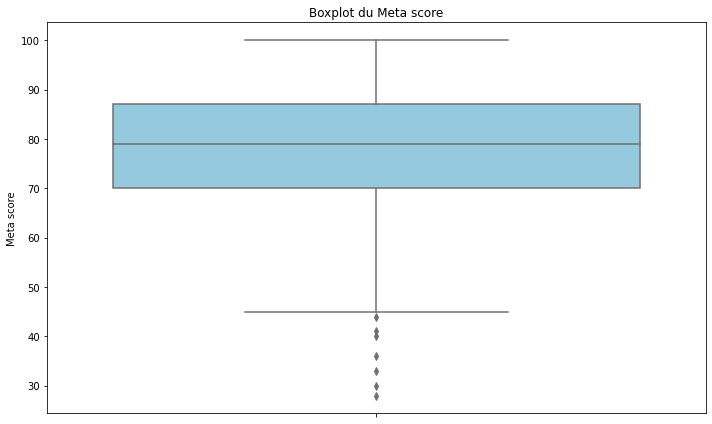

In [ ]:
# Variable Meta_score
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, y='Meta_score', color='skyblue')
plt.title('Boxplot du Meta score')
plt.ylabel('Meta score')
plt.tight_layout()
plt.show()

Le meta socre peut aller de 0 à 100. Ici, aucune valeur ne dépasse cet intervalle. On peut observer des valeurs un peu plus basses que le reste.

##### Variable 'No_of_Votes'

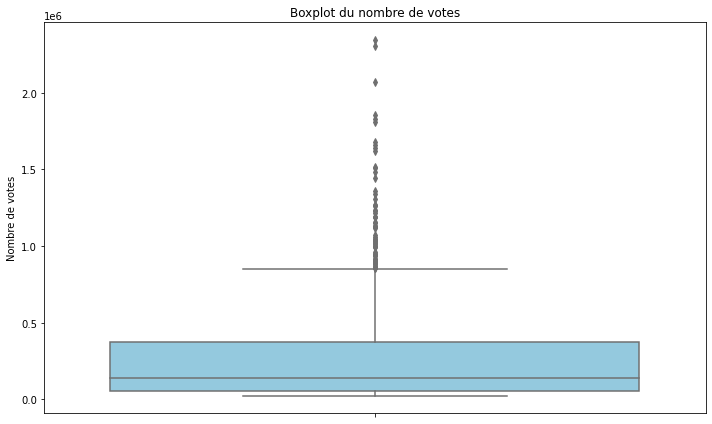

In [ ]:
# Variable Nombre vote
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, y='No_of_Votes', color='skyblue')
plt.title('Boxplot du nombre de votes')
plt.ylabel('Nombre de votes')
plt.tight_layout()
plt.show()

Ici nous pouvons voir que cerains films ont un nombre assez importants de votes.

##### Variable 'Gross'

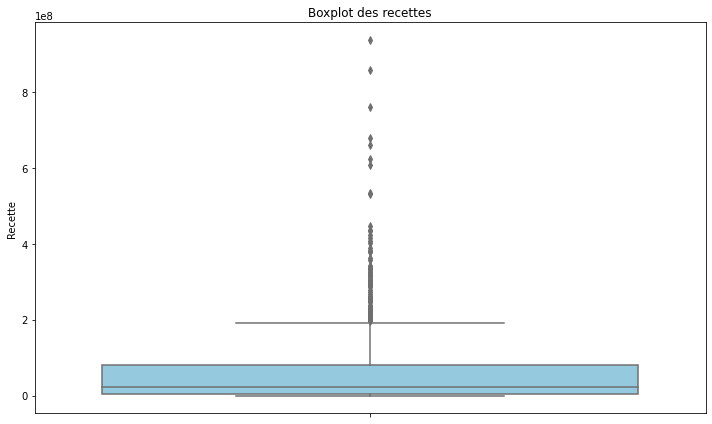

In [ ]:
# Variable recettes
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, y='Gross', color='skyblue')
plt.title('Boxplot des recettes')
plt.ylabel('Recettes')
plt.tight_layout()
plt.show()

De nombreux films semblent avoir des recettes conséquentes.

##### Variable 'runtime_minutes'

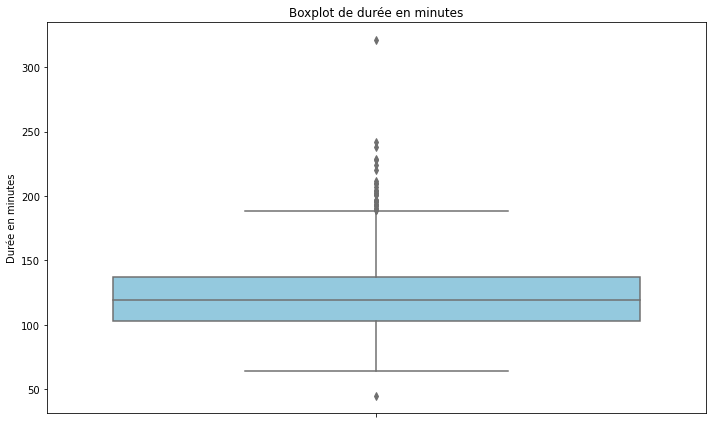

In [ ]:
# Variable durée du film en minutes
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, y='runtime_minutes', color='skyblue')
plt.title('Boxplot de durée en minutes')
plt.ylabel('Durée en minutes')
plt.tight_layout()
plt.show()

Comme vu lors de l'étude graphique de la répartition, nous retrouvons bien des films durant moins de 50 minutes et à l'inverse, un film durant plus de 300 minutes.

##### Traitement des données considérées comme aberrantes

Maintenant que l'étude des variables numériques a été faite pour voir si des valeurs étaient considérées comme aberrantes. Ces valeurs vont être traitées grâce à la méthode de l'isolation forest. Cette méthode consiste à détecter les valeurs anormales dans un jeu de données.
Ici, il repère les lignes considérées comme outliers, puis tu remplaces leurs valeurs problématiques par la moyenne de chaque colonne.

In [ ]:
# Isolation forest
clf = IsolationForest(contamination=0.1, random_state=42)
df_outliers=df_imputed.copy()

colonnes_a_convertir = ['Released_Year', 'IMDB_Rating', 'Meta_score', 'No_of_Votes','Gross','runtime_minutes']
df_outliers['outlier'] = clf.fit_predict(df_outliers[colonnes_a_convertir])

# Remplacement des valeurs aberrantes par la moyenne dans chaque colonne
for col in colonnes_a_convertir:
    mean_col = df_outliers[col].mean()  # Moyenne de la colonne
    df_outliers.loc[df_outliers['outlier'] == -1, col] = mean_col

# Suppression de la colonne des indicateurs d'anomalies
df_outliers = df_outliers.drop(columns=['outlier'])

print(df_outliers)

                                           Poster_Link  \
0    https://m.media-amazon.com/images/M/MV5BMDFkYT...   
1    https://m.media-amazon.com/images/M/MV5BM2MyNj...   
2    https://m.media-amazon.com/images/M/MV5BMTMxNT...   
3    https://m.media-amazon.com/images/M/MV5BMWMwMG...   
4    https://m.media-amazon.com/images/M/MV5BMWU4N2...   
..                                                 ...   
995  https://m.media-amazon.com/images/M/MV5BNGEwMT...   
996  https://m.media-amazon.com/images/M/MV5BODk3Yj...   
997  https://m.media-amazon.com/images/M/MV5BM2U3Yz...   
998  https://m.media-amazon.com/images/M/MV5BZTBmMj...   
999  https://m.media-amazon.com/images/M/MV5BMTY5OD...   

                 Series_Title  Released_Year Certificate   Genre  IMDB_Rating  \
0    The Shawshank Redemption    1991.227018           A   Drama       7.9493   
1               The Godfather    1991.227018           A   Crime       7.9493   
2             The Dark Knight    1991.227018          UA  Ac

In [ ]:
# Remplacement de la démarquation pour les float en . par des ,
for col in df_outliers.select_dtypes(include=['float', 'int']).columns:
    df_outliers[col] = df_outliers[col].astype(str).str.replace('.', ',')

In [ ]:
# Jeu de données final
df_outliers

,Poster_Link,Series_Title,Released_Year,Certificate,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,runtime_minutes
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,"1991,2270179236932",A,Drama,"7,949300000000012",Two imprisoned men bond over a number of years...,"78,30485319076026",Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,"273692,911","61334753,05185654","122,891"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,"1991,2270179236932",A,Crime,"7,949300000000012",An organized crime dynasty's aging patriarch t...,"78,30485319076026",Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,"273692,911","61334753,05185654","122,891"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,"1991,2270179236932",UA,Action,"7,949300000000012",When the menace known as the Joker wreaks havo...,"78,30485319076026",Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,"273692,911","61334753,05185654","122,891"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,"1991,2270179236932",A,Crime,"7,949300000000012",The early life and career of Vito Corleone in ...,"78,30485319076026",Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,"273692,911","61334753,05185654","122,891"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,"1991,2270179236932",U,Crime,"7,949300000000012",A jury holdout attempts to prevent a miscarria...,"78,30485319076026",Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,"273692,911","61334753,05185654","122,891"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,https://m.media-amazon.com/images/M/MV5BNGEwMT...,Breakfast at Tiffany's,"1961,0",A,Comedy,"7,6",A young New York socialite becomes interested ...,"76,0",Blake Edwards,Audrey Hepburn,George Peppard,Patricia Neal,Buddy Ebsen,"166544,0","47218522,609164655","115,0"
996,https://m.media-amazon.com/images/M/MV5BODk3Yj...,Giant,"1991,2270179236932",G,Drama,"7,949300000000012",Sprawling epic covering the life of a Texas ca...,"78,30485319076026",George Stevens,Elizabeth Taylor,Rock Hudson,James Dean,Carroll Baker,"273692,911","61334753,05185654","122,891"
997,https://m.media-amazon.com/images/M/MV5BM2U3Yz...,From Here to Eternity,"1953,0",Passed,Drama,"7,6","In Hawaii in 1941, a private is cruelly punish...","85,0",Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,"43374,0","30500000,0","118,0"
998,https://m.media-amazon.com/images/M/MV5BZTBmMj...,Lifeboat,"1944,0",nan,Drama,"7,6",Several survivors of a torpedoed merchant ship...,"78,0",Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,"26471,0","18959938,474040695","97,0"
